In [1]:
import sys

import pandas as pd
import plotly.express as px
import plotly.graph_objects as pgo
import plotly.io as pio

import wmfdata as wmf
from wmfdata.utils import pd_display_all

In [2]:
sys.path.insert(0, "../src")
from data_access import get_unique_devices, get_page_views
from utils import format_number

In [3]:
pio.templates["nsq"] = pgo.layout.Template(
    layout={
        "font": {
            "family": "Montserrat",
            "size": 16
        },
        "margin": {
            "t": 50,
            "r": 25,
            "b": 25,
            "l": 25
        }
    }
)

pio.templates.default = "plotly+nsq"

In [4]:
countries = wmf.presto.run("""
    WITH country_pv AS (
        SELECT
            country_code,
            SUM(view_count) AS page_views
        FROM wmf.projectview_hourly
        WHERE
            (
                year = 2022 AND month = 12
                OR year = 2023 AND month < 12
            )
            AND agent_type = 'user'
            AND project LIKE '%.wikipedia'
        GROUP BY country_code
    )
    SELECT
        country_code AS country,
        country_code_iso_3 AS country_alpha3_code,
        name AS country_name,
        page_views
    FROM country_pv
    LEFT JOIN canonical_data.countries cdc
        ON country_code = iso_code
    LEFT JOIN gdi.country_meta_data cmd
        ON country_code = country_code_iso_2
""")

In [5]:
switches = (
    pd
    .read_csv("../reference/data_center_switches.tsv", sep="\t", parse_dates=["switch_date"])
    .merge(countries, how="left", on="country")
)

In [42]:
def format_date(x):
    return x.strftime("%Y-%m-%d")

cohort_stats = (
    switches
    .groupby("cohort")
    .agg(
        number_of_countries=("country", "count"),
        first_switch_date=("switch_date", "min"),
        last_switch_date=("switch_date", "max"),
        yearly_page_views=("page_views", "sum")
    )
    .sort_values("first_switch_date")
)

def data_center_cohort_stats(df, data_center_name):
    return (
        df
        .query(f"cohort.str.match('{data_center_name}')")
        .assign(
            yearly_page_views=lambda df: df["yearly_page_views"].apply(format_number),
            first_switch_date=lambda df: df["first_switch_date"].apply(format_date),
            last_switch_date=lambda df: df["last_switch_date"].apply(format_date)

        )
        .rename(
            lambda x: x.replace("_", " "),
            axis="columns"
        )
        .rename(
            lambda x: x.replace(f"{data_center_name}_", "cohort "),
            axis="rows"
        )
        .rename_axis(None, axis="rows")
    )

In [44]:
eqsin_cohort_stats = data_center_cohort_stats(cohort_stats, "eqsin")
eqsin_cohort_stats.to_markdown("../figures/Singapore_cohort_stats.md")
eqsin_cohort_stats

number of countries first switch date last switch date  \
cohort 1                   33        2018-03-22       2018-04-05   
cohort 2                    5        2018-07-19       2018-07-19   

         yearly page views  
cohort 1            39.3 B  
cohort 2            1.13 B

In [45]:
drmrs_cohort_stats = data_center_cohort_stats(cohort_stats, "drmrs")
drmrs_cohort_stats.to_markdown("../figures/Marseille_cohort_stats.md")
drmrs_cohort_stats

number of countries first switch date last switch date  \
cohort 1                    4        2022-03-17       2022-03-23   
cohort 2                    9        2022-06-28       2022-06-28   
cohort 3                   42        2022-08-04       2022-08-12   

         yearly page views  
cohort 1            11.1 B  
cohort 2            8.38 B  
cohort 3            6.51 B

In [10]:
data_centers = (
    pd
    .read_csv("../reference/data_centers.tsv", sep="\t")
    .set_index("name")
)

In [11]:
safe_color_palette = ["#648FFF", "#DC267F", "#FFB000"]

def map_new_data_center(name, city):
    switches_to_here = (
        switches
        .query(f"new_data_center == '{name}'")
        .replace(f"{name}\\_", "cohort ", regex=True)
    )
    
    lat = data_centers.loc[name, "latitude"]
    lon = data_centers.loc[name, "longitude"]
    
    # How do I install Montserrat so that Plotly can access it?
    # tried ~/.fonts, ~/.local/share/fonts, and running `fc-cache` (which
    # seemed to find the fonts)
    fig = px.choropleth(
        switches_to_here,
        locations="country_alpha3_code",
        locationmode="ISO-3",
        color="cohort",
        fitbounds="locations",
        color_discrete_sequence=safe_color_palette,
        width=800,
        # Why does increasing this expand the canvas but not the map?
        height=400,
        title=f"countries switching to the new {city} data center",
    )

    fig.add_scattergeo(
        lat=[lat],
        lon=[lon],
        mode="markers",
        marker_size=10,
        marker_line_width=2,
        marker_symbol="circle-open-dot",
        marker_color="#000",
        name="data center"
    )

    fig.update_layout(
        legend_title_text="",
        title_x=0.5
    )

    return fig

In [12]:
fig = map_new_data_center("eqsin", "Singapore")
fig.write_image("../figures/Singapore_map.png", format="png", scale=2)
fig.show()

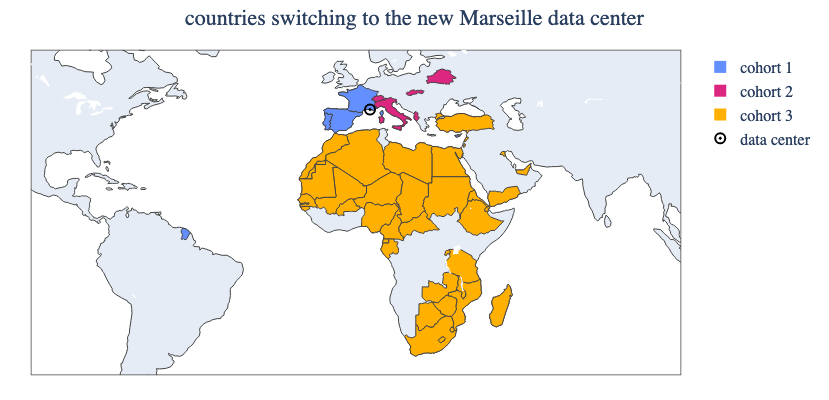

In [13]:
fig = map_new_data_center("drmrs", "Marseille")
fig.write_image("../figures/Marseille_map.png", format="png", scale=2)
fig.show()